# 4.1 Stochastic Calculation of Band Gap Renormalization.
In this example we will learn to do a stochastic Monte Carlo calculation for the band gap renormalization. For this type of calculation we need a phonon restart/checkpoint xml file using a Cartesian phonon calulcation or Normal Mode phonon calculation. 

This calulation is very similar to a normal-mode phonon calculation. First we generate the displacements and then using qbox we compute the total electronic energies and band energies for all displaced coordinates. Last step is very simple. We compute band gaps for each displaced coordinate average over all configurations. This would be our electron-phonon renormalized band gap at that particular temperature.

We need to import pyepfd_io module to read the input file and we need coord_util module to create the displaced coordinate using the Monte Carlo / Stochastic method. Lets import them first.

In [1]:
from pyepfd.coord_util import *
from pyepfd.pyepfd_io import *

          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   
PyEPFD version     :  1.0
Author             : Arp

Next, we will read all information from the checkpoint/restart XML file created in the previous step, i.e., Cartesian phonon calculation. We would instantiate an object named sd_inp (stochastic displacement input) of class read_pyepfd_info that belongs to coord_util object. The class read_pyepfd_info has several objects such as acoustic sum rule (asr), refined dynamical matrix (ref_dynmatrix), optimized coordinates(coord), atoms and cell. 

In [2]:
sd_inp = read_pyepfd_info(file_path='../cartesian_phonon/fdphonon.xml')

Time spent on read_pyepfd_info class: 0.0021054744720458984 s.


Now we will define the input dynamical matrix for stochastic displacement. If refined dynamical matrix (i.e. after performing acoustic sum rule) exists, it would take that one, otherwise it would take dynamical matrix object.

In [3]:
if sd_inp.ref_dynmatrix is not None:
    inp_dynmat = sd_inp.ref_dynmatrix
else:
    inp_dynmat = sd_inp.dynmatrix

Now we will initiate an xyz class in writing mode. Atoms are obtained from atom objects in sd_inp class

In [4]:
sd_xyz = xyz(file_path='mcap.xyz',io='w',atoms=sd_inp.atoms)

Time spent on xyz class: 0.0005991458892822266 s.


Like displacing the atoms during a (E)NMFD phonon calculation, we instantiate an object named sdmoves (stochastic displacement moves) of ionic_mover class. Here we would use mode = 'SD', i.e. stochastic displacement. 

Moreover, we need to provide an algorithm (algo keyword) for stochastic displacement. 6 algorithms are available: 
(1)oneshot ('os'), 

(2)oneshot with antithetic pair ('osap'),

(3)one shot with random sample of signs (osr), this is equivalent to thermal line sampling, see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.014302

(4) Same like 'osr' but with antithetic pairs.

(5)Monte Carlo Sampling of Normal Modes ('mc')

(6) Same as 'mc' but with antithetic pairs of each chosen random sample.

Usually algorithm with antithetic pairs are recommended. Below example we are choosing MCAP. 

Here ngrid is the number of independent samples to be drawn for algorithms 3-6 described above. If an algorithm has antithetic pairs in it then actual numbers of configuration would be 2 times ngrid. In the below example chosen value of ngrid is 250 and so it would generate 500 configurations.

We also need to chose a temperature. In the below example it is 100 K

Therefore, the definition of sdmoves class would read as:

In [5]:
sdmoves = ionic_mover( atoms = sd_inp.atoms,
                       opt_coord = sd_inp.coord, 
                       mode = 'SD', 
                       algo ='mcap', 
                       ngrid = 250,
                       dynmat = inp_dynmat,
                       asr = sd_inp.asr,
                       temperature = 100)

Time spent on ionic_mover class: 0.055777549743652344 s.


Now all the displaced coordinates are stored within sdmoves object. Next step is to write them into an xyz file using the sd_xyz class we initiated before.

In [6]:
for j in range(sdmoves.disp_coord.shape[1]):
    sd_xyz.write(cell = sd_inp.cell,coord = sdmoves.disp_coord[:,j])
del sd_xyz     

In [7]:
%%bash 
ls mcap.xyz

mcap.xyz


Note that the last step was a Monte Carlo simulation that involves pseudo random numbers. Therefore each time you run the sdmoves class it would create a different set of displaced coordinates. Only one OS and OSAP algorithms would produce the same set of coordinates because it does not involves any pseudo random numbers. Let us restart the kernel for completion of the file writing. 


The next step is to prepare the qbox input files for computation of electronic properties, e.g., band energies for these configurations. This step is very similar to the previous examples 1.2 and 2.2. We will use xyz2qbox tool. In this case we do not need to save the wave functions (unlike example 2.2).  

In [8]:
%run ../../../utils/qbox_utils/xyz2qbox.py mcap.xyz

File mcap.xyz has 3 number of atoms in each frame and a total 500 number of frames.
No of species: 2
Present species are: 
O_species
C_species
The file mcap.xyz is an i-PI output with pos_unit: angstrom and cell_unit: angstrom
Enter start frame number: (Default = 1) 
Enter last frame number: (Default = 500) 
Enter step frame: (Default = 1) 
Enter qbox command for 1st iteration: (Default = '  randomize_wf, run -atomic_density 0 100 10')
Hint: more than one commands should be separated by a comma.

Enter qbox run command: (Default = '  run 0 60 10')
Hint: more than one commands should be separated by a comma.
run -atomic_density 0 100 10
Enter qbox plot command: (Default = ' None')
Hints:
      (1) Example: plot options filename (without .cube extension) 
      (2) More than one commands should be separated by a comma.

Enter qbox spectrum command: (Default = ' None')
Hints:
      (1) Example: spectrum options filename (without .dat extension) 
 
Do you want to save sample for each confi

This created a qbox input file with name mcap-1.i. Just like example 1.2, here also multiple input file can be (must for a large system) created. For that purpose the bash wrapper many_xyz2qbox.sh located at util/qbox_util folder can be used instead of running xyz2qbox.py multiple times. The next step is to submit those jobs and wait until all calculations finished properly.

Here we already computed the HOMO-LUMOs for a set of MC trajectory (saved_example.xyz) generated for the same temperature and same algorithm. The related qbox input file is saved_example-1.i and the output file is saved_example-1.r. Taking this output file as an example, I will show how to compute renormalized bad gap. 

First we will extract the Kon-Sham eigenvalues for HOMO (band 7,8) and LUMO.

In [9]:
%%bash
source ../../../env.sh
rm -rf Eigenvalues #Removing the previous existing Eigenvalues folder
extract_eigval.sh -prefix saved_example -seq 1 1 -orb 7 9

In [10]:
%%bash
cat orbital_kp_0_0_0.dat

#Orbital-7	#Orbital-8	#Orbital-9
-10.487170364117	-10.477806462848	-1.023844849688
-10.491930996223	-10.476740223367	-1.056185101151
-10.485337121956	-10.475223504189	-1.081698326149
-10.465087173793	-10.443357728981	-1.267443801201
-10.472053419490	-10.465358595320	-0.970187929921
-10.512543172977	-10.512527824290	-0.898384711847
-10.527799679100	-10.517207132901	-0.923443428935
-10.478123219864	-10.462103393953	-1.148608321486
-10.339938214676	-10.339440662568	-0.954741724093
-10.423617068754	-10.401157571192	-1.244167491779
-10.532306461367	-10.529566959494	-0.894040197086
-10.409028400597	-10.399754091388	-1.076863441171
-10.477285216996	-10.465041191181	-1.139326536596
-10.448040183680	-10.431506465550	-1.111545941111
-10.478714643717	-10.467120526323	-1.114443749835
-10.491228021287	-10.489006381255	-0.958756414210
-10.487713978646	-10.474126658401	-0.999063507444
-10.486938627166	-10.481050436941	-1.025233757119
-10.421068833951	-10.403397269651	-1.193176789321
-10.375467136826	

-10.385252987856	-10.378299460795	-1.063874441742
-10.433717650145	-10.432767616456	-0.918345652252
-10.472618250553	-10.449282880883	-1.133423909055
-10.452755551916	-10.448601148111	-0.958315619928
-10.474357394468	-10.464193885324	-1.034812141934
-10.456456498686	-10.450715777026	-1.036339911823
-10.462404976325	-10.447791397204	-1.180916718890
-10.485921798723	-10.485649074179	-0.900476165680
-10.475486477422	-10.465967430042	-1.066566446688
-10.463989230023	-10.459366943993	-1.031750314928
-10.477861236669	-10.457539174220	-0.994415905981
-10.409495355533	-10.396685024798	-1.026764966920
-10.509075327593	-10.498217115596	-0.967525236894
-10.419105379690	-10.402341538773	-1.051696481820
-10.454481222621	-10.448107689556	-1.193776020330
-10.467267762885	-10.448538163837	-1.152923887481
-10.388242269581	-10.367948899501	-1.145597917563
-10.463061327031	-10.438860185110	-1.188427834847
-10.493332433957	-10.484442005575	-1.029615813155
-10.449249166993	-10.414198752294	-1.335105245328


-10.492663653854	-10.479320811473	-1.010170030010
-10.479477517205	-10.460253317795	-1.022615865359
-10.476147233802	-10.473552986533	-1.020154881464
-10.322822460412	-10.306310623629	-1.182852528801
-10.347970001277	-10.326647337815	-0.983693527581
-10.430539452475	-10.367344473975	-1.831703020047
-10.443681887506	-10.427779731657	-1.164589163344
-10.494594864628	-10.491761076600	-0.964374376430
-10.240190986976	-10.227544225556	-1.072398934220
-10.476558335384	-10.470390191291	-1.059522736433
-10.438555141346	-10.415659710225	-1.079547083966
-10.487487868555	-10.475356094945	-1.064291692105
-10.455813966143	-10.436557769414	-1.358250523289
-10.482565028119	-10.472629121922	-1.051002865452
-10.492912732612	-10.484960780251	-1.022158493379
-10.510507825713	-10.508464145035	-0.934354966711
-10.422543943352	-10.403342577191	-1.330013885676
-10.461191210997	-10.428180816200	-1.405996240029
-10.445791481398	-10.430575887314	-1.201418149009
-10.479084686013	-10.473660217330	-0.989841681300


-10.489043134112	-10.483845818115	-0.923798143694
-10.509350627991	-10.494059398709	-0.934068906284
-10.439531086790	-10.437581900120	-0.889585419527
-10.475448722865	-10.474979847278	-0.934306135414
-10.510871603261	-10.501712687749	-0.950091033918
-10.468573953432	-10.451434722903	-1.195247010356
-10.522294144420	-10.511181059735	-0.931941869897
-10.473726551778	-10.456790370306	-1.009029776296


Generated orbital_kp_0_0_0.dat file lists energies for bands 7,8 (HOMO) and 9 (LUMO) for all 500 sampled configurations. We will compute the average HOMO energy for each configurations by taking the average energies of band 7 and 8. Then we compute the band gap for each configurations by subtracting the average HOMO energy from LUMO energy (band 9). 

This can be easily done using an "awk" command.

In [11]:
%%bash
awk '{print $3-($1+$2)/2}' orbital_kp_0_0_0.dat | sed '1d' > gap.dat
cat gap.dat

9.45864
9.42815
9.39858
9.18678
9.49852
9.61415
9.59906
9.3215
9.38495
9.16822
9.6369
9.32753
9.33184
9.32823
9.35847
9.53136
9.48186
9.45876
9.21906
9.35677
9.42319
9.53196
9.45107
9.62031
9.61705
9.44551
9.52979
9.23763
9.2816
9.36085
9.16861
9.23916
9.41404
9.39599
9.39987
9.2091
9.30875
9.51932
9.41909
9.58121
9.58176
9.43941
9.50511
9.37513
9.23489
9.21201
9.4021
9.54027
9.40991
9.4678
9.35561
9.49012
9.58553
9.52872
9.44789
9.50401
9.45865
9.23949
9.2086
9.44666
9.4221
9.45757
9.58631
9.39916
9.5824
9.16378
9.60536
9.45554
9.55704
9.60734
9.56913
9.53666
9.35893
9.22105
9.38327
9.33927
9.34785
9.55908
9.3761
9.23449
9.60971
9.25374
8.94998
8.73059
9.39897
9.55359
9.16238
9.56872
9.17106
9.45788
9.45501
9.48626
9.5101
9.54018
9.40492
9.20515
9.44015
9.51206
9.31234
9.40304
9.4659
9.6138
9.42128
9.47172
9.51328
9.58198
8.83639
9.62859
9.57122
9.50514
9.47339
9.45934
9.17174
9.01087
9.4803
9.58453
9.12643
9.43884
9.4614
9.37981
9.30314
9.59777
9.52183
9.48432
9.08598
9.21437
9.37721

To obtain the renormalized gap, the next step is to average over all 500 configurations. 

/home/arku/.local/lib/python3.8/site-packages/pyepfd/epfd.py:286: RuntimeWarning: invalid value encountered in double_scalars
  sd_mean = np.sqrt( np.var(data_chunk, axis = axis)/float(data_chunk.shape[0] - 1) )


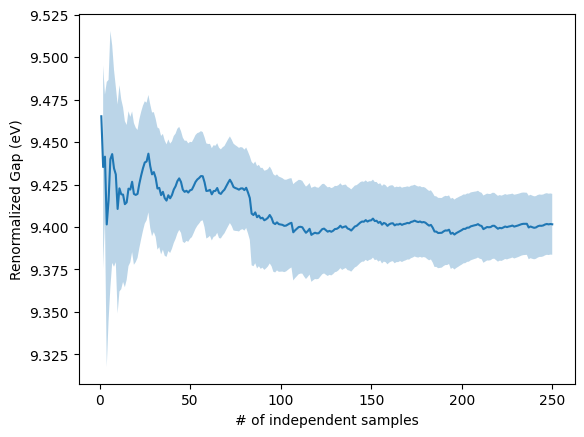

In [12]:
from pyepfd.epfd import mc_convergence
import matplotlib.pyplot as plt
co2_100K = mc_convergence(file_path='gap.dat',algo='mcap', usecols=(0))
mc = co2_100K.avg[:,0] #Our gap was in column 0 of the file
emc = 2*co2_100K.sd_mean[:,0] # Error is 2 times standard deviation of mean
plt.plot( [i+1 for i in range(len(mc))], mc, label='MC')
plt.fill_between([i+1 for i in range(len(mc))], mc + emc, mc - emc, alpha = 0.3)
plt.xlabel("# of independent samples")
plt.ylabel("Renormalized Gap (eV)")
plt.show()